## 실제 학습

In [ ]:
import torch
from tqdm import tqdm
from network.conv_node import NODE
from misc import *
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.multimodal import CLIPImageQualityAssessment
import time

# GPU 번호 지정
gpu_number = 2  # 원하는 GPU 번호로 변경 가능

# GPU 사용 제한
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

# 이제 GPU가 한 개만 보이므로 cuda:0으로 접근
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


model = NODE(device, (3, 256, 256), 32, augment_dim=0, time_dependent=True, adjoint=True)
model.eval()
model.to(device)
model.load_state_dict(torch.load(f'/home/lbw/CLODE/pth/universal.pth', weights_only=True), strict=False)

file_path = Path('/home/lbw/data/our485')
# img_labels = sorted(os.listdir(file_path / 'low'))
img_labels = [f for f in sorted(os.listdir(file_path / 'low')) if f.lower().endswith('.png')]

def load_image(idx):
    lq_img = image_tensor(file_path / 'low' / img_labels[idx], size=(256, 256))
    gt_img = image_tensor(file_path / 'high' / img_labels[idx], size=(256, 256))
    
    return lq_img.to(device), gt_img.to(device)


prompts = ('brightness', 'noisiness', 'quality', 'contrast')  # 단순 튜플로 변경

clip_metric = CLIPImageQualityAssessment(
    model_name_or_path="openai/clip-vit-base-patch16",
    prompts=prompts  # 이미 적절한 형식을 가진 튜플
).to(device)

def calculate_clip_score(pred, prompts=prompts):    
    # 이미 배치 차원이 있는지 확인하고 없으면 추가
    if len(pred.shape) == 3:
        pred = pred.unsqueeze(0)
    
    with torch.no_grad():
        # 한 번의 forward pass로 모든 프롬프트에 대한 점수를 계산
        scores = clip_metric(pred)

    # 결과 반환 (scores는 리스트 형태로 반환됨)
    return scores[prompts[0]].item(), scores[prompts[1]].item(), scores[prompts[2]].item(), scores[prompts[3]].item()

# 메인 루프 최적화
T_values = np.linspace(2, 5, 30)

results = []
brightness_scores = []
noisiness_scores = []
quality_scores = []
contrast_scores = []

# T 값들을 먼저 텐서로 변환하여 반복 변환 방지
T_tensors = [torch.tensor([0, T]).float().cuda() for T in T_values]

with torch.no_grad():
    for idx in tqdm(range(len(img_labels))):
        lq_img, gt_img = load_image(idx)
        high_psnr = 0.0
        best_T = 2.0
        
        # 모든 T에 대한 예측을 한 번에 계산
        preds = []
        psnrs = []
        
        for i, T_tensor in enumerate(T_tensors):
            pred = model(lq_img, T_tensor, inference=True)['output'][0]
            preds.append(pred)
            psnr = calculate_psnr(pred, gt_img).item()
            psnrs.append(psnr)
            
            if high_psnr < psnr:
                high_psnr = psnr
                best_T = T_values[i]
        
        # 모든 예측에 대해 CLIP 점수 계산
        for i, pred in enumerate(preds):
            bright_score, noise_score, quality_score, contrast_score = calculate_clip_score(pred)
            brightness_scores.append([idx, T_values[i], bright_score])
            noisiness_scores.append([idx, T_values[i], noise_score])
            quality_scores.append([idx, T_values[i], quality_score])
            contrast_scores.append([idx, T_values[i], contrast_score])
        
        results.append([best_T, high_psnr])

save_path = Path('/home/lbw/CLODE/scores_csv_4prompts')
save_path.mkdir(parents=True, exist_ok=True)

results = np.array(results)
np.save(Path(save_path / 'results.npy'), results)

brightness_scores = np.array(brightness_scores)
noisiness_scores = np.array(noisiness_scores)
quality_scores = np.array(quality_scores)
contrast_scores = np.array(contrast_scores)

np.save(Path(save_path / 'brightness_scores.npy'), brightness_scores)
np.save(Path(save_path / 'noisiness_scores.npy'), noisiness_scores)
np.save(Path(save_path / 'quality_scores.npy'), quality_scores)
np.save(Path(save_path / 'contrast_scores.npy'), contrast_scores)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from network.clip_regressor import TtoTRegressor
import random
from utils.load_data import load_and_prepare_data


# random seed 고정
random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
np.random.seed(random_seed)
random.seed(random_seed)

# GPU 번호 지정
gpu_number = 3  # 원하는 GPU 번호로 변경 가능

# GPU 사용 제한
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

# 이제 GPU가 한 개만 보이므로 cuda:0으로 접근
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [2]:
# # 데이터 로드
# save_path = Path('/home/lbw/CLODE_scores_npy')

# results = np.load(save_path / 'results.npy')
# brightness_scores = np.load(save_path / 'brightness_scores.npy')  # [idx, T_value, score] 형태
# noisiness_scores = np.load(save_path / 'noisiness_scores.npy')    # [idx, T_value, score] 형태
# quality_scores = np.load(save_path / 'quality_scores.npy')        # [idx, T_value, score] 형태
# print(results.shape, brightness_scores.shape, noisiness_scores.shape, quality_scores.shape)
# print(brightness_scores[:31, :3])
# # 데이터 로드
# print(results[:, 0])

총 이미지 수: 485
T 값의 개수: 30
총 데이터 포인트: 14550
T 값 범위: 2.0 ~ 5.0

유니크 T 값 분포:


/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/IPython/core/pylabtools.

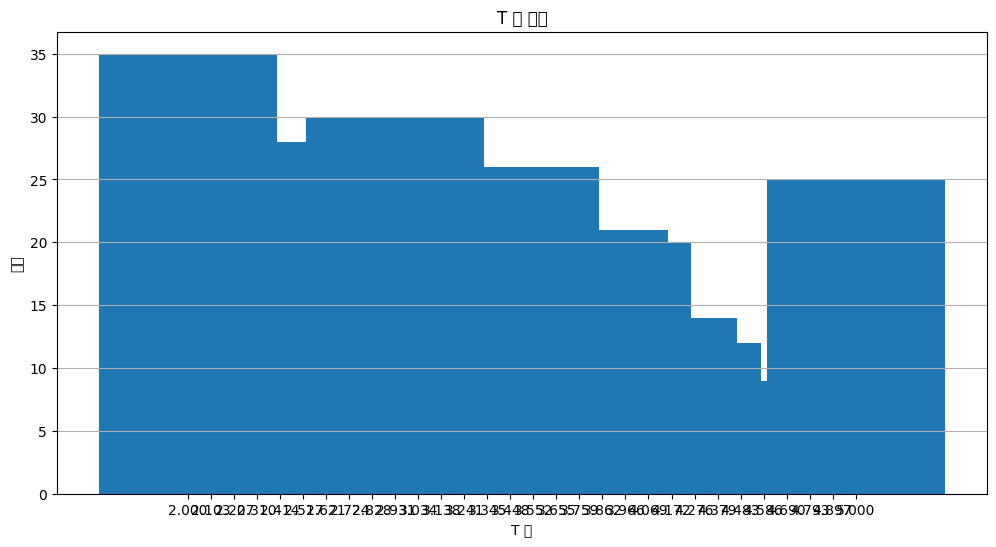


학습 데이터: torch.Size([388, 30, 3]), torch.Size([388])
테스트 데이터: torch.Size([97, 30, 3]), torch.Size([97])


In [3]:

# 데이터 로드 및 준비
scores_path = '/home/lbw/CLODE_scores_npy'
data = load_and_prepare_data(
    scores_path=scores_path,
    test_size=0.2, 
    batch_size=16, 
    random_seed=42,
    visualize=True,
)

# 필요한 데이터 추출
train_loader = data['train_loader']
test_loader = data['test_loader']
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
input_dim = data['input_dim']
unique_T_values = data['unique_T_values']


총 이미지 수: 485
T 값의 개수: 30
총 데이터 포인트: 14550
T 값 범위: 2.0 ~ 5.0

유니크 T 값 분포:

학습 데이터: torch.Size([388, 30, 3]), torch.Size([388])
테스트 데이터: torch.Size([97, 30, 3]), torch.Size([97])


/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Progress: 100%|██████████| 3000/3000 [12:33<00:00,  3.98it/s, Train Loss=0.310249, Test Loss=0.265779, Best Epoch=6]



학습 완료! 최적 에포크: 6, 최적 테스트 손실: 0.257000
모델 저장 완료: /home/lbw/CLODE_model/att_regression_64_0.0001_6.pth


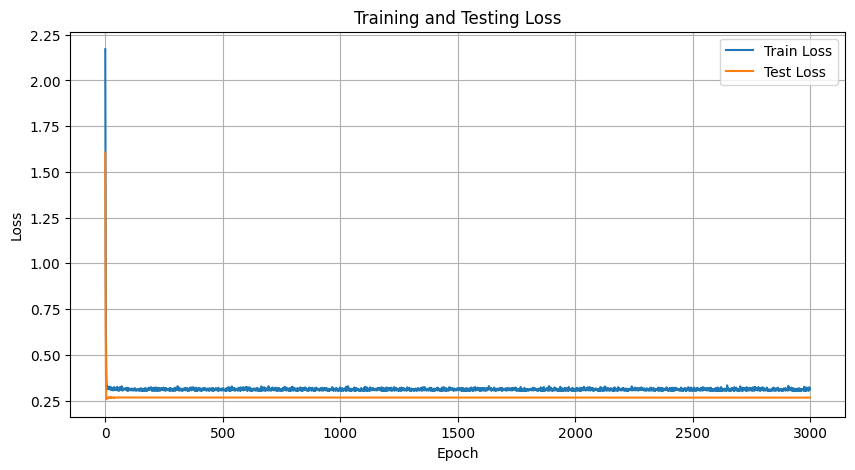

/home/lbw/CLODE/utils/train_visualize.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path_name))


MAE: 0.6765, RMSE: 0.7982


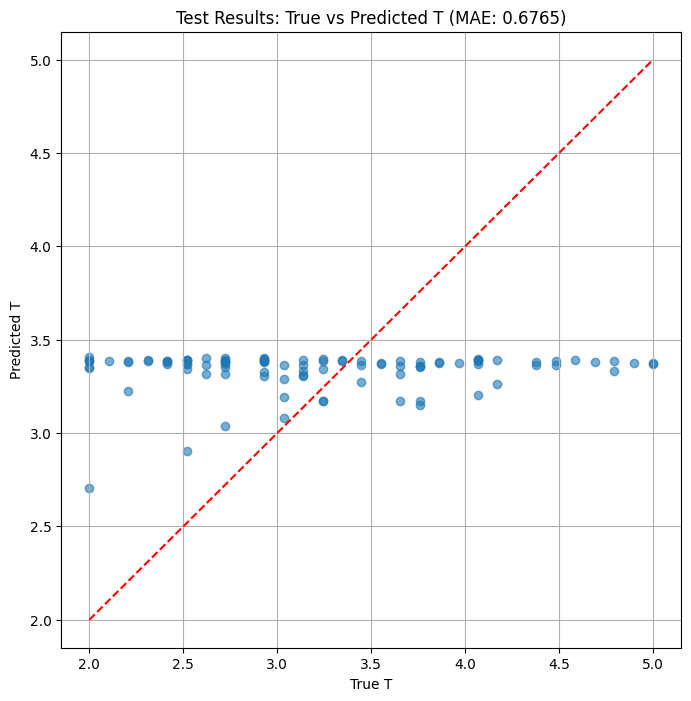

MAE: 0.6748, RMSE: 0.8130


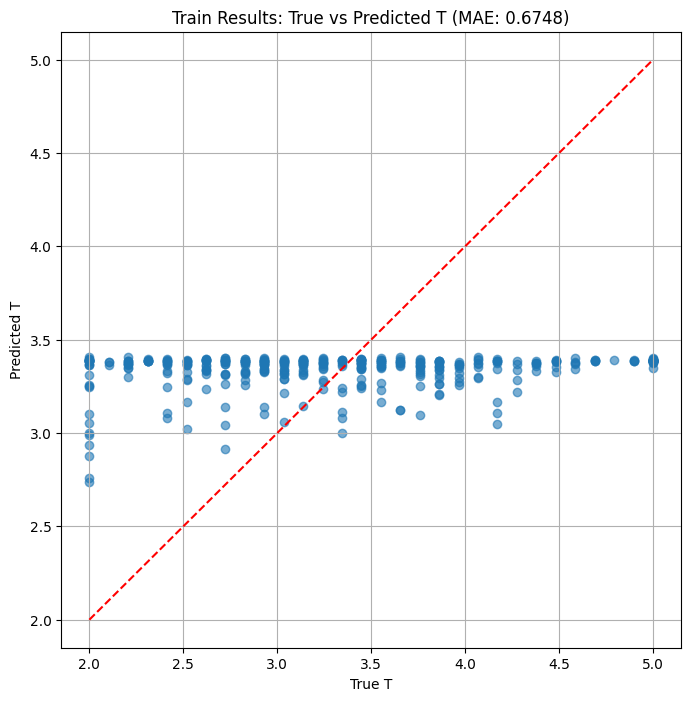


===== 결과 요약 =====
최적 에포크: 6
학습 데이터 - MAE: 0.6748, RMSE: 0.8130
테스트 데이터 - MAE: 0.6765, RMSE: 0.7982


In [ ]:
# from utils.train_visualize import initialize_model, train_epoch, evaluate, train_model, save_model, plot_losses, evaluate_and_visualize

# # 메인 함수
# def main(hidden_dim=64, learning_rate=1e-4, num_epochs=3000):
#     # 디바이스 설정
#     # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     model_path = Path("/home/lbw/CLODE_model")
#     model_path.mkdir(exist_ok=True, parents=True)
    
#     # 데이터 로드 및 준비 (이 부분은 이전에 함수화된 데이터 로더 사용)
#     data = load_and_prepare_data('/home/lbw/CLODE_scores_npy')
#     train_loader = data['train_loader']
#     test_loader = data['test_loader']
#     X_train = data['X_train']
#     X_test = data['X_test']
#     y_train = data['y_train']
#     y_test = data['y_test']
#     input_dim = data['input_dim']
#     unique_T_values = data['unique_T_values']

#     # 모델 초기화
#     regressor, criterion_reg, optimizer_reg, scheduler = initialize_model(
#         input_dim, hidden_dim, device, learning_rate, loss_type='huber'
#     )
    
#     # 모델 학습
#     train_losses, test_losses, best_model, best_epoch = train_model(
#         regressor, train_loader, test_loader, criterion_reg, optimizer_reg, 
#         scheduler, device, num_epochs
#     )
    
#     # 최적 모델 저장
#     model_path_name = save_model(best_model, hidden_dim, learning_rate, best_epoch, model_path)
    
#     # 손실 시각화
#     plot_losses(train_losses, test_losses, model_path / 'regression_training.png')
    
#     # 테스트 데이터에 대한 평가 및 시각화
#     # regressor, _, _, _ = initialize_model(input_dim, hidden_dim, device, learning_rate)
#     mae_test, rmse_test, _, _ = evaluate_and_visualize(
#         regressor, X_test, y_test, model_path_name, device, 
#         title='Test Results', save_path=model_path / f'test_results_{hidden_dim}_{learning_rate}_{best_epoch}.png'
#     )
    
#     # 학습 데이터에 대한 평가 및 시각화
#     mae_train, rmse_train, _, _ = evaluate_and_visualize(
#         regressor, X_train, y_train, model_path_name, device, 
#         title='Train Results', save_path=model_path / f'train_results_{hidden_dim}_{learning_rate}_{best_epoch}.png'
#     )
    
#     # 결과 요약 출력
#     print("\n===== 결과 요약 =====")
#     print(f"최적 에포크: {best_epoch}")
#     print(f"학습 데이터 - MAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}")
#     print(f"테스트 데이터 - MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}")

# # 실행을 위한 코드
# if __name__ == "__main__":

#     # 하이퍼파라미터 설정
#     hidden_dim = 64
#     learning_rate = 1e-4
#     num_epochs = 3000

#     main(hidden_dim=hidden_dim, learning_rate=learning_rate, num_epochs=num_epochs)

In [5]:
if

SyntaxError: invalid syntax (4110802630.py, line 1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# 학습 루프
num_epochs = 3000
train_losses = []
test_losses = []
best_test_loss = 10
best_epoch = 0
learning_rate = 1e-4

input_dim = input_dim
hidden_dim = 64

# 모델, 손실 함수, 옵티마이저 초기화
regressor = TtoTRegressor(input_dim, hidden_dim).to(device)
# criterion_reg = nn.MSELoss()  # 회귀 문제이므로 MSE 손실 사용
# criterion_reg = nn.L1Loss()  # MAE 손실 사용
criterion_reg = torch.nn.HuberLoss(delta=1.0)

optimizer_reg = optim.Adam(regressor.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode='min', factor=0.5, patience=10, verbose=True)


for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    regressor.train()
    epoch_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # 예측 및 손실 계산
        y_pred = regressor(X_batch)
        # print(y_pred)
        loss = criterion_reg(y_pred, y_batch)
        
        # 역전파 및 최적화
        optimizer_reg.zero_grad()
        loss.backward()
        optimizer_reg.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # 테스트 데이터로 평가
    regressor.eval()
    test_loss = 0.0
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = regressor(X_batch)
            test_loss += criterion_reg(y_pred, y_batch).item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model = regressor.state_dict()
            best_epoch = epoch
    
    
    # if (epoch + 1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')


# 모델 저장
model_path = "/home/lbw/CLODE_model"
model_path = Path(model_path)
model_path.mkdir(exist_ok=True, parents=True)

model_name = f'att_regression_{hidden_dim}_{learning_rate}_{best_epoch}.pth'

model_path_name = model_path / model_name

torch.save(best_model, model_path_name)
print(f"epoch{epoch}_모델 학습 및 저장 완료!")


# 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.savefig(model_path / 'regression_training.png')
plt.show()

# 예측 평가
regressor = TtoTRegressor(input_dim, hidden_dim).to(device)
regressor.eval()
regressor.load_state_dict(torch.load(model_path_name))
with torch.no_grad():
    X_test_reg_device = X_test.to(device)
    y_pred = regressor(X_test_reg_device).cpu().numpy()
    y_true = y_test.numpy()
    
    # 평균 절대 오차 (MAE) 계산
    mae = np.mean(np.abs(y_pred - y_true))
    # 평균 제곱근 오차 (RMSE) 계산
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    print('y_pred:', y_pred)
    print('y_true:', y_true)
    # 예측 vs 실제 시각화
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True T')
    plt.ylabel('Predicted T')
    plt.title('Regression Results: True vs Predicted T')
    plt.grid(True)
    plt.savefig(model_path / f'test_results_{hidden_dim}_{learning_rate}_{best_epoch}.png')
    plt.show()

with torch.no_grad():
    X_test_reg_device = X_train.to(device)
    y_pred = regressor(X_test_reg_device).cpu().numpy()
    y_true = y_train.numpy()
    
    # 평균 절대 오차 (MAE) 계산
    mae = np.mean(np.abs(y_pred - y_true))
    # 평균 제곱근 오차 (RMSE) 계산
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    
    # 예측 vs 실제 시각화
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True T')
    plt.ylabel('Predicted T')
    plt.title('Regression Results: True vs Predicted T')
    plt.grid(True)
    plt.savefig(model_path / f'train_results_{hidden_dim}_{learning_rate}_{best_epoch}.png')
    plt.show()

/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Progress:   0%|          | 10/3000 [00:02<12:08,  4.11it/s]

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# from pathlib import Path
# from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt

# # 회귀 모델 정의
# class TtoTRegressor_multi(nn.Module):
#     def __init__(self, input_dim=3, hidden_dim=32):
#         super(TtoTRegressor_multi, self).__init__()
#         # 데이터 형태 가져오기
#         batch_size, T, features = X.shape  # X는 전역 변수로 정의되어 있어야 함
#         self.T = T  # 클래스 변수로 T 저장
        
#         # 입력 차원: 각 배치에 대해 T*features
#         total_input_dim = T * features
        
#         self.mlp = nn.Sequential(
#             nn.Linear(total_input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, T)  # 출력은 각 T에 대한 점수
#         )
        
#     def forward(self, x):
#         # x shape: (batch_size, T, features)
#         batch_size, T, features = x.shape
#         x_reshaped = x.reshape(batch_size, T*features)  # (batch_size, T*features)
        
#         # MLP를 통과시켜 각 T에 대한 점수 계산
#         scores = self.mlp(x_reshaped)  # (batch_size, T)
        
#         # 가중 평균으로 최종 T 값 계산
#         weights = torch.softmax(scores, dim=1)  # (batch_size, T)
        
#         # T 값들에 대한 가중 합
#         T_values = torch.FloatTensor(unique_T_values).to(x.device)  # (T,)
#         T_pred = torch.sum(weights * T_values.unsqueeze(0), dim=1)  # (batch_size,)
        
#         return T_pred



# # 학습 루프
# num_epochs = 1000
# train_losses = []
# test_losses = []
# best_test_loss = 10
# best_epoch = 0
# learning_rate = 1e-4

# input_dim = 3
# hidden_dim = 64

# # 모델, 손실 함수, 옵티마이저 초기화
# regressor = TtoTRegressor_multi(input_dim, hidden_dim).to(device)
# criterion_reg = nn.MSELoss()  # 회귀 문제이므로 MSE 손실 사용
# optimizer_reg = optim.Adam(regressor.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_reg, mode='min', factor=0.5, patience=10, verbose=True)


# for epoch in range(num_epochs):
#     regressor.train()
#     epoch_loss = 0.0
    
#     for X_batch, y_batch in train_loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)
        
#         # 예측 및 손실 계산
#         y_pred = regressor(X_batch)
#         loss = criterion_reg(y_pred, y_batch)
        
#         # 역전파 및 최적화
#         optimizer_reg.zero_grad()
#         loss.backward()
#         optimizer_reg.step()
        
#         epoch_loss += loss.item()
    
#     avg_train_loss = epoch_loss / len(train_loader)
#     train_losses.append(avg_train_loss)
    
#     # 테스트 데이터로 평가
#     regressor.eval()
#     test_loss = 0.0
#     with torch.no_grad():
#         total = 0
#         correct = 0
#         total_loss = 0
        
#         for X_batch, y_batch in test_loader:
#             X_batch = X_batch.to(device)
#             y_batch = y_batch.to(device)
            
#             y_pred = regressor(X_batch)
#             test_loss += criterion_reg(y_pred, y_batch).item()
    
#     avg_test_loss = test_loss / len(test_loader)
#     test_losses.append(avg_test_loss)
    
#     if test_loss < best_test_loss:
#             best_test_loss = test_loss
#             best_model = classifier.state_dict()
#             best_epoch = epoch
    
    
#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')


# # 모델 저장
# model_path = "/home/lbw/CLODE_model"
# model_path = Path(model_path)
# model_path.mkdir(exist_ok=True, parents=True)

# torch.save(best_model, model_path / f'tto_regression_multi_{hidden_dim}_{learning_rate}_{best_epoch}.pth')
# print(f"epoch{epoch}_모델 학습 및 저장 완료!")


# # 결과 시각화
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Train Loss')
# plt.plot(test_losses, label='Test Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Mean Squared Error')
# plt.title('Training and Testing Loss')
# plt.legend()
# plt.grid(True)
# plt.savefig(model_path / f'regression_mul_training_{hidden_dim}_{learning_rate}_{best_epoch}.png')
# plt.show()

# # 예측 평가
# regressor.eval()
# with torch.no_grad():
#     X_test_reg_device = X_test.to(device)
#     y_pred = regressor(X_test_reg_device).cpu().numpy()
#     y_true = y_test.numpy()
    
#     # 평균 절대 오차 (MAE) 계산
#     mae = np.mean(np.abs(y_pred - y_true))
#     # 평균 제곱근 오차 (RMSE) 계산
#     rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
#     print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')
    
#     # 예측 vs 실제 시각화
#     plt.figure(figsize=(8, 8))
#     plt.scatter(y_true, y_pred, alpha=0.6)
#     plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
#     plt.xlabel('True T')
#     plt.ylabel('Predicted T')
#     plt.title('Regression Results: True vs Predicted T')
#     plt.grid(True)
#     plt.savefig(save_path / f'regression_mul_results_{hidden_dim}_{learning_rate}_{best_epoch}.png')
#     plt.show()

## Clip_score based T로 시각화

/tmp/ipykernel_686339/692039427.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  regressor.load_state_dict(torch.load(model_path_name, map_location=device))
100%|███████

모든 이미지 처리 완료!


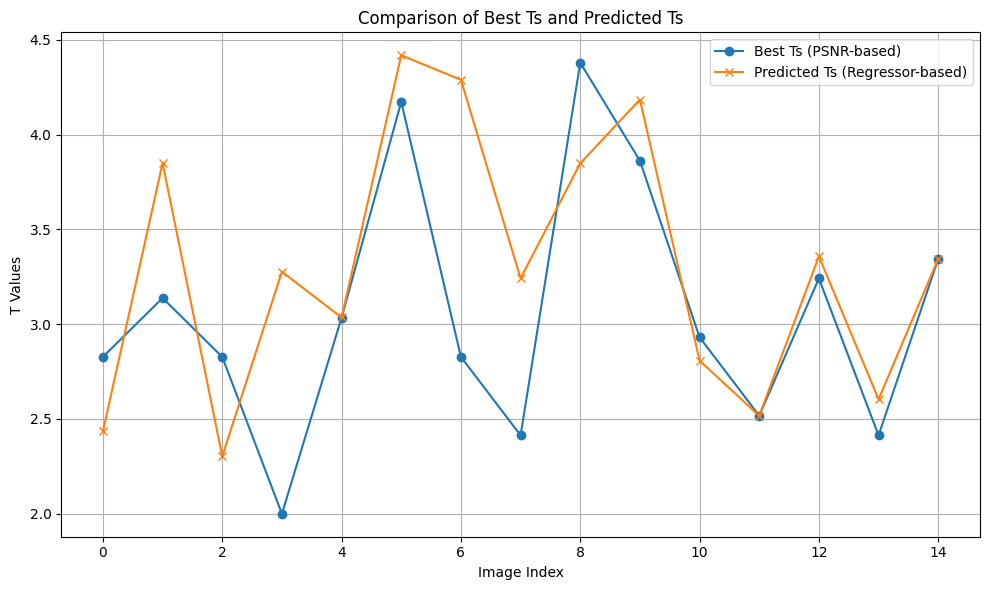

Best T PSNR 평균: 24.29dB
Predicted T PSNR 평균: 20.23dB
Best T SSIM 평균: 0.8241
Predicted T SSIM 평균: 0.7787


In [2]:
import torch
from tqdm import tqdm
from network.conv_node import NODE
# from network.clip_classifier import TtoTClassifier
from misc import *
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.multimodal import CLIPImageQualityAssessment
import time
from network.clip_regressor import TtoTRegressor
from skimage.metrics import structural_similarity as ssim

# GPU 번호 지정
gpu_number = 3  # 원하는 GPU 번호로 변경 가능

# GPU 사용 제한
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

# 이제 GPU가 한 개만 보이므로 cuda:0으로 접근
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = NODE(device, (3, 256, 256), 32, augment_dim=0, time_dependent=True, adjoint=True)
model.eval()
model.to(device)
model.load_state_dict(torch.load(f'/home/lbw/CLODE/pth/universal.pth', weights_only=True), strict=False)

# 하이퍼파라미터 설정
input_dim = 3
hidden_dim = 64
num_layers = 3

# 모델 초기화
regressor = TtoTRegressor(input_dim, hidden_dim).to(device)
regressor.eval()
regressor.to(device)
model_path_name = '/home/lbw/CLODE_model/att_regression_64_0.0001_567.pth'
regressor.load_state_dict(torch.load(model_path_name, map_location=device))

file_path = Path('/home/lbw/data/eval15')

# img_labels = sorted(os.listdir(file_path / 'low'))
img_labels = [f for f in sorted(os.listdir(file_path / 'low')) if f.lower().endswith('.png')]

# 필요한 함수들 정의
prompts = ('brightness', 'noisiness', 'quality')
clip_metric = CLIPImageQualityAssessment(
    model_name_or_path="openai/clip-vit-base-patch16",
    prompts=prompts
).to(device)

def calculate_clip_score(pred):    
    if len(pred.shape) == 3:
        pred = pred.unsqueeze(0)
    
    with torch.no_grad():
        scores = clip_metric(pred)
    
    return scores[prompts[0]].item(), scores[prompts[1]].item(), scores[prompts[2]].item()

# eval15 데이터 불러오기
eval_path = Path('/home/lbw/data/eval15')
eval_images = [f for f in sorted(os.listdir(eval_path / 'low')) if f.lower().endswith('.png')]

def load_eval_image(idx):
    img_name = eval_images[idx]
    lq_img = image_tensor(eval_path / 'low' / img_name, size=(256, 256))
    gt_img = image_tensor(eval_path / 'high' / img_name, size=(256, 256))
    
    return lq_img.to(device), gt_img.to(device), img_name

def tensor_to_numpy(tensor):
    """PyTorch 텐서를 NumPy 배열로 변환합니다."""
    # GPU -> CPU 이동 및 계산 그래프에서 분리
    img = tensor.detach().cpu().numpy()
    
    # 이미지 형식 변환 (C,H,W) -> (H,W,C)
    if img.ndim == 3 and img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    
    # 값 범위 조정 [0, 1]
    img = np.clip(img, 0, 1)
    
    return img

def calculate_ssim(img1, img2):
    """
    두 이미지 간의 SSIM(구조적 유사성) 계산
    
    Args:
        img1 (torch.Tensor): 첫 번째 이미지 텐서
        img2 (torch.Tensor): 두 번째 이미지 텐서
        
    Returns:
        float: SSIM 값 (0~1 사이, 1이 가장 유사함)
    """
    # GPU 텐서를 CPU로 이동 후 NumPy 배열로 변환
    # 차원 확인 및 정규화
    if len(img1.shape) == 4:  # (B,C,H,W) 형태인 경우
        img1 = img1[0]  # (C,H,W) 형태로 변경
    if len(img2.shape) == 4:  # (B,C,H,W) 형태인 경우
        img2 = img2[0]  # (C,H,W) 형태로 변경
    
    img1_np = tensor_to_numpy(img1)
    img2_np = tensor_to_numpy(img2)
    
    # tensor_to_numpy 함수를 통해 이미 (H,W,C) 형태로 변환되었으므로
    # channel_axis는 2로 설정
    return ssim(img1_np, img2_np, channel_axis=2, data_range=1.0)

# 메인 루프 최적화
T_values = np.linspace(2, 5, 30)

# T 값들을 먼저 텐서로 변환하여 반복 변환 방지
T_tensors = [torch.tensor([0, T]).float().cuda() for T in T_values]

# 결과 저장을 위한 디렉토리 생성
results_dir = Path('/home/lbw/CLODE_eval_results_atten')
results_dir.mkdir(parents=True, exist_ok=True)

best_Ts = []
pred_Ts = []
best_psnrs = []
pred_psnrs = []
best_ssims = []  # SSIM 결과 저장용
pred_ssims = []  # SSIM 결과 저장용

# 이미지별 NODE와 Classifier 결과 비교
for idx in tqdm(range(len(eval_images))):
    lq_img, gt_img, img_name = load_eval_image(idx)
    
    # 모든 T에 대한 예측 수행
    preds = []
    psnrs = []
    ssims = []  # SSIM 값 저장 리스트
    
    with torch.no_grad():
        for T_tensor in T_tensors:
            pred = model(lq_img, T_tensor, inference=True)['output'][0]
            preds.append(pred)
            psnr = calculate_psnr(pred, gt_img).item()
            psnrs.append(psnr)
            # SSIM 계산 추가
            ssim_value = calculate_ssim(pred, gt_img)
            ssims.append(ssim_value)
    
    
    # PSNR 기반 best_T 찾기
    best_T_idx = np.argmax(psnrs)
    best_T = T_values[best_T_idx]
    best_pred = preds[best_T_idx]
    
    best_Ts.append(best_T)
    best_psnrs.append(psnrs[best_T_idx])
    best_ssims.append(ssims[best_T_idx])  # 최적 T의 SSIM 저장
    
    
    # CLIP 점수 계산 및 행렬 구성
    clip_scores = np.zeros((len(preds), 3))
    for i, pred in enumerate(preds):
        bright_score, noise_score, quality_score = calculate_clip_score(pred)
        clip_scores[i] = [bright_score, noise_score, quality_score]
    
    # Classifier 모델로 예측
    clip_scores_tensor = torch.FloatTensor(clip_scores).unsqueeze(0).to(device)  # (1, T, 3) 형태로 변환
    with torch.no_grad():
        pred_T = regressor(clip_scores_tensor)
        pred_T = pred_T.item()
        
    
    pred_T_idx = np.argmin(np.abs(T_values - pred_T))
    pred_img = preds[pred_T_idx]
    
    pred_Ts.append(pred_T)
    pred_psnrs.append(psnrs[pred_T_idx])
    pred_ssims.append(ssims[pred_T_idx])  # 예측 T의 SSIM 저장
    
    
    # 시각화
    plt.figure(figsize=(20, 15))
    
    # 원본 저화질 이미지
    plt.subplot(2, 2, 1)
    plt.imshow(tensor_to_numpy(lq_img[0]))
    plt.title(f'Low Quality Image: {img_name}')
    plt.axis('off')
    
    # 원본 고화질 이미지
    plt.subplot(2, 2, 2)
    plt.imshow(tensor_to_numpy(gt_img[0]))
    plt.title('Ground Truth')
    plt.axis('off')
    
    # PSNR 기반 best_T 이미지
    plt.subplot(2, 2, 3)
    plt.imshow(tensor_to_numpy(best_pred))
    plt.title(f'NODE Best T={best_T:.2f}, PSNR={psnrs[best_T_idx]:.2f}dB, SSIM={ssims[best_T_idx]:.4f}')
    plt.axis('off')
    
    # Regressor 예측 T 이미지
    plt.subplot(2, 2, 4)
    plt.imshow(tensor_to_numpy(pred_img))
    plt.title(f'Regressor Pred T={pred_T:.2f}, PSNR={psnrs[pred_T_idx]:.2f}dB, SSIM={ssims[pred_T_idx]:.4f}')
    plt.axis('off')
    
    # 결과 저장
    plt.tight_layout()
    plt.savefig(results_dir / f'{img_name.split(".")[0]}_compare.png')
    plt.close()

# 통계 정보 계산 (전체 이미지에 대해)
print("모든 이미지 처리 완료!")

# best_Ts와 pred_Ts를 하나의 플롯에 시각화
plt.figure(figsize=(10, 6))
plt.plot(best_Ts, label='Best Ts (PSNR-based)', marker='o')
plt.plot(pred_Ts, label='Predicted Ts (Regressor-based)', marker='x')
plt.xlabel('Image Index')
plt.ylabel('T Values')
plt.title('Comparison of Best Ts and Predicted Ts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(results_dir / 'best_vs_pred_Ts.png')
plt.show()

# PSNR 비교
print(f"Best T PSNR 평균: {np.mean(best_psnrs):.2f}dB")
print(f"Predicted T PSNR 평균: {np.mean(pred_psnrs):.2f}dB")
print(f"Best T SSIM 평균: {np.mean(best_ssims):.4f}")
print(f"Predicted T SSIM 평균: {np.mean(pred_ssims):.4f}")
